# Detecting Hate Speech on Twitter

In [2]:
import spacy
import pandas as pd
import csv
import unicodedata
import seaborn as sns
from sklearn.model_selection import train_test_split
from spacy.lang.es.stop_words import STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import plot_confusion_matrix
import re
import string

In [3]:
nlp = spacy.load('es_core_news_sm')

In [5]:
df = pd.read_csv('data/train_es.csv',sep='\t')

## Exploring the dataset

In [6]:
df.head()

,id,text,HS,TR,AG
0,20001,Easyjet quiere duplicar el número de mujeres p...,1,0,0
1,20002,El gobierno debe crear un control estricto de ...,1,0,0
2,20003,Yo veo a mujeres destruidas por acoso laboral ...,0,0,0
3,20004,"— Yo soy respetuoso con los demás, sólamente l...",0,0,0
4,20007,Antonio Caballero y como ser de mal gusto e ig...,0,0,0


In [7]:
df.shape

(4450, 5)

In [8]:
df.drop(['TR', 'AG'], axis=1)

,id,text,HS
0,20001,Easyjet quiere duplicar el número de mujeres p...,1
1,20002,El gobierno debe crear un control estricto de ...,1
2,20003,Yo veo a mujeres destruidas por acoso laboral ...,0
3,20004,"— Yo soy respetuoso con los demás, sólamente l...",0
4,20007,Antonio Caballero y como ser de mal gusto e ig...,0
...,...,...,...
4445,24996,@miriaan_ac @Linaveso_2105 @HumildesSquad_ CÁL...,1
4446,24997,"@IvanDuque presidente en Cúcuta , tenemos prob...",1
4447,24998,- Callaté Visto Que Te Dejo En Puta🎤🎶,0
4448,24999,-¿porque los hombres se casan con las mujeres?...,1


<AxesSubplot:xlabel='HS', ylabel='count'>

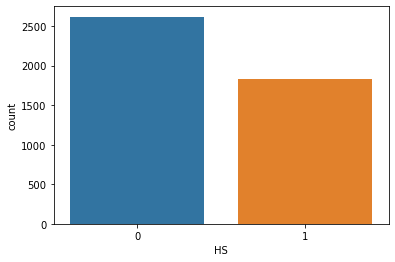

In [9]:
sns.countplot(x='HS', data=df)

## Cleaning and tokenizing 

In [10]:
with open('data/spanish.txt') as f:
    stopwords = f.read().splitlines()

In [11]:
sw = " ".join(sw for sw in stopwords)

In [12]:
negative = df[df.HS==1]

In [13]:
text = " ".join(tw for tw in negative.text)
print ("There are {} words in the combination of all tweets.".format(len(text)))

There are 234193 words in the combination of all tweets.


In [14]:
def normalize(text):

    try:
        text = unicode(text, 'utf-8')
    except NameError: # unicode is a default on python 3 
        pass

    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")\
    
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text) #removing numbers and words with numbers

    return str.lower(text)

In [15]:
stopwords_normalized = normalize(sw)

In [16]:
text_normalized = normalize(text)

### Tokenizing

In [17]:
def text_data_cleaning(sentence):
    doc = nlp(sentence)
    
    tokens = []
    for token in doc:
        temp = token.lower_
        tokens.append(temp)
    
    cleaned_tokens = []
    for token in tokens:
        if token not in stopwords_normalized and token.strip() != "":
            
            cleaned_tokens.append(token)
    return cleaned_tokens

In [18]:
tweets = [tweet for tweet in df.text]

In [19]:
data_cleaned = [text_data_cleaning(normalize(row)) for row in tweets]

## Visualization: Wordcloud

In [20]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text_normalized)

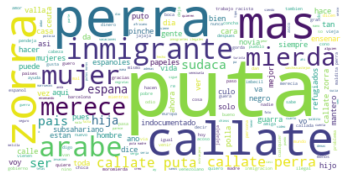

In [21]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Visualization: LDA and Topic Modelling

In [176]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

In [68]:
# Create Dictionary
id2word = corpora.Dictionary(data_cleaned)

In [69]:
# Term Document Frequency
texts = data_cleaned

In [70]:
# Create Corpus
corpus = [id2word.doc2bow(text) for text in texts]

In [71]:
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]


In [72]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

[[('aparcar', 1),
  ('avion', 1),
  ('duplicar', 1),
  ('easyjet', 1),
  ('mujeres', 1),
  ('numero', 1),
  ('piloto', 1),
  ('quiere', 1),
  ('veras', 1)],
 [('colombia', 1),
  ('control', 1),
  ('crear', 1),
  ('debe', 1),
  ('despues', 1),
  ('estricto', 1),
  ('fronterizas', 1),
  ('gobierno', 1),
  ('inmigracion', 1),
  ('masa', 1),
  ('venir', 1),
  ('zonas', 1)]]

In [75]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [76]:
# Print the Keyword in the 2 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.008*"arabe" + 0.008*"acoso" + 0.006*"arabes" + 0.006*"inmigrantes" + 0.006*"pais" + 0.005*"mujeres" + 0.005*"violacion" + 0.005*"inmigracion" + 0.004*"indocumentados" + 0.004*"espana"'), (1, '0.041*"puta" + 0.023*"callate" + 0.014*"perra" + 0.011*"zorra" + 0.008*"hijo" + 0.008*"mereces" + 0.007*"mierda" + 0.006*"madre" + 0.005*"mujer" + 0.005*"polla"')]


In [177]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/laurasg/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.147793  0.0       1        1  57.682041
0     -0.147793  0.0       2        1  42.317959, topic_info=          Term         Freq        Total Category  logprob  loglift
63        puta  1122.000000  1122.000000  Default  30.0000  30.0000
97     callate   640.000000   640.000000  Default  29.0000  29.0000
216      perra   391.000000   391.000000  Default  28.0000  28.0000
84       zorra   290.000000   290.000000  Default  27.0000  27.0000
481      arabe   168.000000   168.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
3364  mientras    45.052652    49.408635   Topic2  -6.0983   0.7677
228       aqui    53.361014    63.404457   Topic2  -5.9290   0.6875
158       solo    51.823362   129.288611   Topic2  -5.9583  -0.0542
515        dia    37.501413    68.568295   Topic2  -6.2817   0.2565
150       hace    37.177279    84.215206   Topic2  -6.2904   0.0423

[105 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
21        1  0.006180      acoso
21        2  0.995017      acoso
228       1  0.157718       aqui
228       2  0.835903       aqui
481       1  0.005950      arabe
...     ...       ...        ...
169       2  0.009814       vida
41        2  0.994928  violacion
488       1  0.999501        voy
488       2  0.013882        voy
84        1  0.998259      zorra

[101 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [178]:
pyLDAvis.save_html(vis, 'lda.html')

/Users/laurasg/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Models

## TFIDF - SVC

## TFIDF

In [22]:
tfidf = TfidfVectorizer(tokenizer = text_data_cleaning)

In [23]:
X = df['text']
y = df['HS']

In [24]:
X = tfidf.fit_transform(X)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 74, shuffle=True)
X_train.shape, X_test.shape

((3560, 18594), (890, 18594))

## SMOTE Oversampling

In [26]:
oversample = SMOTE()

In [27]:
res_X, res_y = oversample.fit_resample(X, y)

In [28]:
res_y.value_counts()

1    2617
0    2617
Name: HS, dtype: int64

In [29]:
X_train, X_test, y_train, y_test= train_test_split(res_X,res_y, test_size=0.2, random_state= 74)

## SVC Classifier

In [30]:
classifier = LinearSVC()

In [31]:
classifier.fit(X_train, y_train)

LinearSVC()

In [32]:
y_pred = classifier.predict(X_test)

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       530
           1       0.84      0.86      0.85       517

    accuracy                           0.85      1047
   macro avg       0.85      0.85      0.85      1047
weighted avg       0.85      0.85      0.85      1047



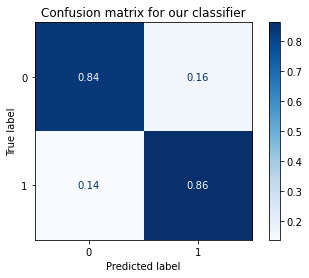

In [34]:
matrix = plot_confusion_matrix(classifier, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for our classifier')
plt.show(matrix)
plt.show()

## TFIDF - Naive Bayes

## Bernoulli Naive Bayes

In [35]:
classifier = BernoulliNB()

In [36]:
classifier.fit(X_train, y_train)

BernoulliNB()

In [37]:
y_pred = classifier.predict(X_test)

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       530
           1       0.84      0.81      0.82       517

    accuracy                           0.83      1047
   macro avg       0.83      0.83      0.83      1047
weighted avg       0.83      0.83      0.83      1047



## TFIDF - Logistic Regression

## Logistic Regression

In [39]:
classifier = LogisticRegression()

In [40]:
classifier.fit(X_train, y_train)

LogisticRegression()

In [41]:
y_pred = classifier.predict(X_test)

In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.83      0.83       530
           1       0.83      0.81      0.82       517

    accuracy                           0.82      1047
   macro avg       0.82      0.82      0.82      1047
weighted avg       0.82      0.82      0.82      1047



## BOW - SVC

## BOW

In [43]:
bow_vector = CountVectorizer(tokenizer = text_data_cleaning, ngram_range=(1,1))

In [44]:
X = df['text']
y = df['HS']

In [45]:
X = bow_vector.fit_transform(X)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 74, shuffle=True)
X_train.shape, X_test.shape

((3560, 18594), (890, 18594))

## SMOTE

In [47]:
oversample = SMOTE()

In [48]:
res_X, res_y = oversample.fit_resample(X, y)

In [49]:
X_train, X_test, y_train, y_test= train_test_split(res_X,res_y, test_size=0.2, random_state= 74)

## SVC

In [50]:
classifier = LinearSVC()

In [51]:
classifier.fit(X_train, y_train)

LinearSVC()

In [52]:
y_pred = classifier.predict(X_test)

In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.74      0.79       530
           1       0.77      0.86      0.81       517

    accuracy                           0.80      1047
   macro avg       0.80      0.80      0.80      1047
weighted avg       0.81      0.80      0.80      1047



## BOW - Naive Bayes

## Bernoulli Naive Bayes

In [54]:
classifier = BernoulliNB()

In [55]:
classifier.fit(X_train, y_train)

BernoulliNB()

In [56]:
y_pred = classifier.predict(X_test)

In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.58      0.69       530
           1       0.68      0.91      0.78       517

    accuracy                           0.74      1047
   macro avg       0.77      0.74      0.73      1047
weighted avg       0.77      0.74      0.73      1047



## BOW - Logistic Regression 

## Logistic Regression

In [58]:
classifier = LogisticRegression()

In [59]:
classifier.fit(X_train, y_train)

/Users/laurasg/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [60]:
y_pred = classifier.predict(X_test)

In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80       530
           1       0.78      0.85      0.81       517

    accuracy                           0.81      1047
   macro avg       0.81      0.81      0.81      1047
weighted avg       0.81      0.81      0.81      1047



## BIGRAM VECTOR - SVC

In [62]:
bigram_vector = CountVectorizer(tokenizer = text_data_cleaning, ngram_range=(2,2))

In [63]:
X = df['text']
y = df['HS']

In [64]:
X = bigram_vector.fit_transform(X)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 74, shuffle=True)
X_train.shape, X_test.shape

((3560, 49170), (890, 49170))

In [66]:
oversample = SMOTE()

In [67]:
res_X, res_y = oversample.fit_resample(X, y)

In [68]:
X_train, X_test, y_train, y_test= train_test_split(res_X,res_y, test_size=0.2, random_state= 74)

In [69]:
classifier = LinearSVC()

In [70]:
classifier.fit(X_train, y_train)

LinearSVC()

In [71]:
y_pred = classifier.predict(X_test)

In [72]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.35      0.50       530
           1       0.59      0.95      0.73       517

    accuracy                           0.65      1047
   macro avg       0.74      0.65      0.62      1047
weighted avg       0.74      0.65      0.61      1047

